Реализация алгоритма Actor Critic для среды [Cart Pole](https://www.gymlibrary.ml/environments/classic_control/cart_pole/)

In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(800, 600))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""


def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [4]:
# HIDE OUTPUT
env = wrap_env(gym.make("CartPole-v1"))

observation = env.reset()

while True:

    env.render()

    # your agent goes here
    action = env.action_space.sample()

    observation, reward, done, info = env.step(action)

    if done:
        break

env.close()
show_video()

In [5]:
import torch
import random
from torch import nn

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [7]:
class ActorNetwork(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(state_space_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, action_space_dim)
        )

    def forward(self, x):
        return self.network(x)


In [8]:
class ValueNetwork(nn.Module):

    def __init__(self, state_space_dim):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(state_space_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.network(x)


In [9]:
class ActorCriticAgent:
    def __init__(self, state_space_dim, action_space_dim):
        self.gamma = 0.99
        self.state_space_dim = state_space_dim
        self.action_space_dim = action_space_dim

        self.actor_net = ActorNetwork(state_space_dim, action_space_dim)
        self.actor_opt = torch.optim.Adam(self.actor_net.parameters(), lr=1e-4)

        self.value_net = ValueNetwork(state_space_dim)
        self.value_opt = torch.optim.Adam(self.value_net.parameters(), lr=1e-3)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():
            net_out = self.actor_net(state)

        action_prob = torch.softmax(net_out, 0).detach().cpu().numpy()
        return np.random.choice(2, p=action_prob)

    def update_policy(self, state1_batch, action_batch, reward_batch, state2_batch, done_batch):
        state1_batch = torch.tensor(state1_batch, dtype=torch.float32)
        action_batch = torch.tensor(action_batch, dtype=torch.int64)
        reward_batch = torch.tensor(reward_batch, dtype=torch.float32).unsqueeze(1)
        state2_batch = torch.tensor(state2_batch, dtype=torch.float32)
        done_batch = torch.tensor(done_batch, dtype=torch.float32)

        with torch.no_grad():
            state1_value = self.value_net(state1_batch)
            state2_value = self.value_net(state2_batch)
            target_value = (reward_batch + (1 - done_batch) * self.gamma * state2_value)

        advantage = target_value - state1_value
        advantage = advantage.detach()

        log_probs = torch.log_softmax(self.actor_net(state1_batch), 1)
        log_like = torch.gather(log_probs, 1, action_batch.unsqueeze(1))

        actor_loss = -(advantage * log_like).mean()

        self.actor_opt.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor_net.parameters(), 100)
        self.actor_opt.step()

        loss2 = (self.value_net(state1_batch) - target_value) ** 2
        loss2 = loss2.mean()

        self.value_opt.zero_grad()
        loss2.backward()
        self.value_opt.step()


In [10]:
def run_episode(agent, env, episode_history):
    state1 = env.reset()

    episode_reward = 0

    max_steps = 200
    for step in range(max_steps):
        action = agent.choose_action(state1)

        state2, reward, done, info = env.step(action)

        episode_reward += reward

        if done:
            reward -= 10

        episode_history.append((state1, action, reward, state2, done))

        if done:
            break

        state1 = state2
    return episode_reward


In [11]:

env = gym.make("CartPole-v1")

total_episodes = 2000

agent = ActorCriticAgent(4, 2)

rewards = []
smooth_rewards = []

for episode in tqdm(range(0, total_episodes)):
        episode_history = []

        episode_reward = run_episode(agent, env, episode_history)

        rewards.append(episode_reward)

        smooth_rewards.append(np.mean(rewards[-10:]))

        state1_batch = []
        action_batch = []
        reward_batch = []
        state2_batch = []
        done_batch = []

        for state1, action, reward, state2, done in episode_history:
            state1_batch.append(state1)
            action_batch.append(action)
            reward_batch.append(reward)
            state2_batch.append(state2)
            done_batch.append(done)

        agent.update_policy(state1_batch, action_batch, reward_batch, state2_batch, done_batch)


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


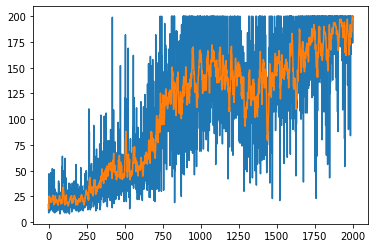

In [12]:
plt.plot(rewards)
plt.plot(smooth_rewards)
plt.show()


In [13]:
env = wrap_env(gym.make("CartPole-v1"))

observation = env.reset()

while True:

    env.render()
    
    action = agent.choose_action(observation)

    observation, reward, done, info = env.step(action)

    if done:
        break

env.close()
show_video()